In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable # importing Variable from torch.autograd
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('BTC-USD.csv', index_col = 'Date', parse_dates=True)
df.drop(columns=['Adj Close'], inplace=True)
df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


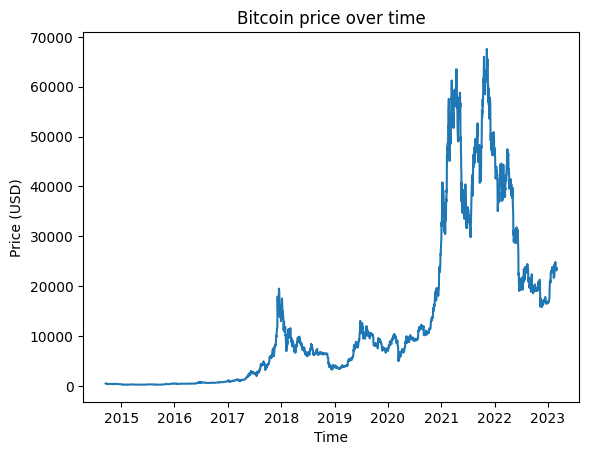

In [3]:
plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price over time")
plt.savefig("initial_plot.png", dpi=250)
plt.show()

In [4]:
X, y = df.drop(columns=['Close']), df.Close.values
print(X.shape, y.shape)

(3088, 4) (3088,)


In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

In [6]:
X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))
print(X_trans.shape, y_trans.shape)

(3088, 4) (3088, 1)


In [7]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

In [8]:
X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)
print(X_ss.shape, y_mm.shape)

(2940, 100, 4) (2940, 50)


In [9]:
assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()

In [10]:
# assert checking with next line
print(y_mm[0])

[0.00209093 0.00222324 0.00204426 0.00206468 0.00199688 0.00196819
 0.00210851 0.00202031 0.00203193 0.00152813 0.00127754 0.00143008
 0.00160392 0.00172483 0.00156177 0.00166652 0.00143485 0.00129928
 0.00133098 0.00070869 0.         0.00047101 0.00044509 0.00031395
 0.00047836 0.00054546 0.00049284 0.00072407 0.00082066 0.00081284
 0.00103495 0.00112207 0.00141522 0.00126686 0.00082821 0.00082224
 0.00071706 0.00058409 0.00072518 0.00089223 0.00072957 0.00072341
 0.00057885 0.00065535 0.00073678 0.00067235 0.00062335 0.00061933
 0.00060963 0.0006479 ]


In [11]:
print(y_trans[99:149].squeeze(1))

[0.00209093 0.00222324 0.00204426 0.00206468 0.00199688 0.00196819
 0.00210851 0.00202031 0.00203193 0.00152813 0.00127754 0.00143008
 0.00160392 0.00172483 0.00156177 0.00166652 0.00143485 0.00129928
 0.00133098 0.00070869 0.         0.00047101 0.00044509 0.00031395
 0.00047836 0.00054546 0.00049284 0.00072407 0.00082066 0.00081284
 0.00103495 0.00112207 0.00141522 0.00126686 0.00082821 0.00082224
 0.00071706 0.00058409 0.00072518 0.00089223 0.00072957 0.00072341
 0.00057885 0.00065535 0.00073678 0.00067235 0.00062335 0.00061933
 0.00060963 0.0006479 ]


In [12]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)
print(train_test_cutoff)

2779


In [13]:
# rounding 2940 - 2779 = 161 to 150
X_train = X_ss[:-150]
X_test = X_ss[-150:]

In [14]:
y_train = y_mm[:-150]
y_test = y_mm[-150:]

In [15]:
print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

Training Shape: (2790, 100, 4) (2790, 50)
Testing Shape: (150, 100, 4) (150, 50)


In [16]:
# convert to pytorch tensors
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [17]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,
                                      (X_train_tensors.shape[0], 100,
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,
                                     (X_test_tensors.shape[0], 100,
                                      X_test_tensors.shape[2]))

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape: torch.Size([2790, 100, 4]) torch.Size([2790, 50])
Testing Shape: torch.Size([150, 100, 4]) torch.Size([150, 50])


In [18]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
# assert checking with next line
print(X_check[-1][0:4])

[[1.96235840e+04 2.03803438e+04 1.95238398e+04 3.58872787e+10]
 [2.03359004e+04 2.03437480e+04 1.98018008e+04 3.32237906e+10]
 [2.01610391e+04 2.04083926e+04 1.99000879e+04 3.47114130e+10]
 [1.99575586e+04 2.00410859e+04 1.93957930e+04 2.92273154e+10]]


In [19]:
print(X.iloc[-149:-145])

                    Open          High           Low       Volume
Date                                                             
2022-10-04  19623.583984  20380.343750  19523.839844  35887278685
2022-10-05  20335.900391  20343.748047  19801.800781  33223790572
2022-10-06  20161.039063  20408.392578  19900.087891  34711412966
2022-10-07  19957.558594  20041.085938  19395.792969  29227315390


In [20]:
# assert checking with next line
print(y_check[-1])

[17934.896484 18869.587891 19909.574219 20976.298828 20880.798828
 21169.632813 21161.519531 20688.78125  21086.792969 22676.552734
 22777.625    22720.416016 22934.431641 22636.46875  23117.859375
 23032.777344 23078.728516 23031.089844 23774.566406 22840.138672
 23139.283203 23723.769531 23471.871094 23449.322266 23331.847656
 22955.666016 22760.109375 23264.291016 22939.398438 21819.039063
 21651.183594 21870.875    21788.203125 21808.101563 22220.804688
 24307.841797 23623.474609 24565.601563 24641.277344 24327.642578
 24829.148438 24436.353516 24188.84375  23947.492188 23198.126953
 23175.375    23561.212891 23522.871094 23147.353516 23646.550781]


In [21]:
print(df.Close.values[-50:])

[17934.896484 18869.587891 19909.574219 20976.298828 20880.798828
 21169.632813 21161.519531 20688.78125  21086.792969 22676.552734
 22777.625    22720.416016 22934.431641 22636.46875  23117.859375
 23032.777344 23078.728516 23031.089844 23774.566406 22840.138672
 23139.283203 23723.769531 23471.871094 23449.322266 23331.847656
 22955.666016 22760.109375 23264.291016 22939.398438 21819.039063
 21651.183594 21870.875    21788.203125 21808.101563 22220.804688
 24307.841797 23623.474609 24565.601563 24641.277344 24327.642578
 24829.148438 24436.353516 24188.84375  23947.492188 23198.126953
 23175.375    23561.212891 23522.871094 23147.353516 23646.550781]


In [22]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes  # output size
        self.num_layers = num_layers  # number of recurrent layers in the lstm
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # neurons in each lstm layer
        
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2)  # lstm
        self.fc_1 = nn.Linear(hidden_size, 128)  # fully connected
        self.fc_2 = nn.Linear(128, num_classes)  # fully connected last layer
        self.relu = nn.ReLU()
    def forward(self, x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))  # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size)  # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out)  # first dense
        out = self.relu(out)  # relu
        out = self.fc_2(out)  # final output
        return out

In [23]:
def training_loop(n_epochs, lstm, optimizer, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimizer.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimizer.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch,
                                                                      loss.item(),
                                                                      test_loss.item()))

In [24]:
# lstm parameters
n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 4 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 2 # number of stacked lstm layers, can be 2

num_classes = 50 # number of output classes

lstm = LSTM(num_classes,
              input_size,
              hidden_size,
              num_layers)

optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()

In [25]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimizer=optimizer,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.15269, test loss: 0.12586
Epoch: 100, train loss: 0.01417, test loss: 0.06380
Epoch: 200, train loss: 0.01134, test loss: 0.08323
Epoch: 300, train loss: 0.00693, test loss: 0.03522
Epoch: 400, train loss: 0.00436, test loss: 0.00476
Epoch: 500, train loss: 0.00400, test loss: 0.00293
Epoch: 600, train loss: 0.00385, test loss: 0.00251
Epoch: 700, train loss: 0.00376, test loss: 0.00241
Epoch: 800, train loss: 0.00371, test loss: 0.00234
Epoch: 900, train loss: 0.00367, test loss: 0.00227


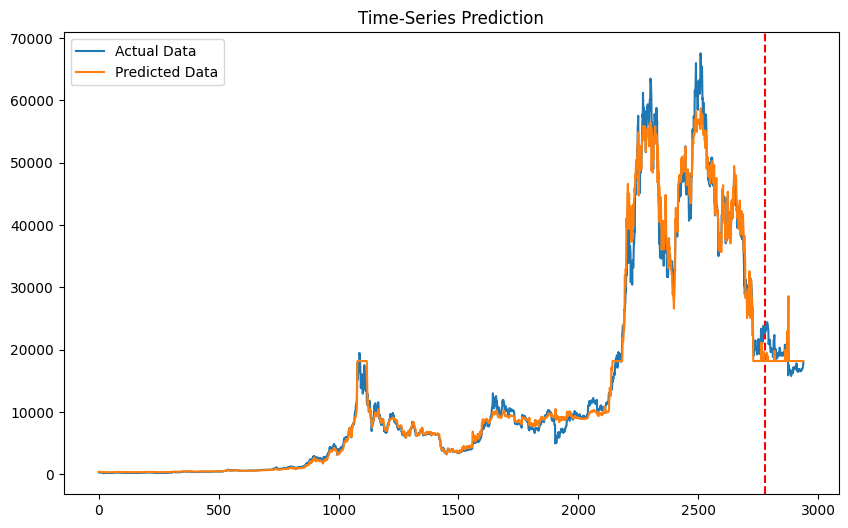

In [26]:
# plot
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show() 

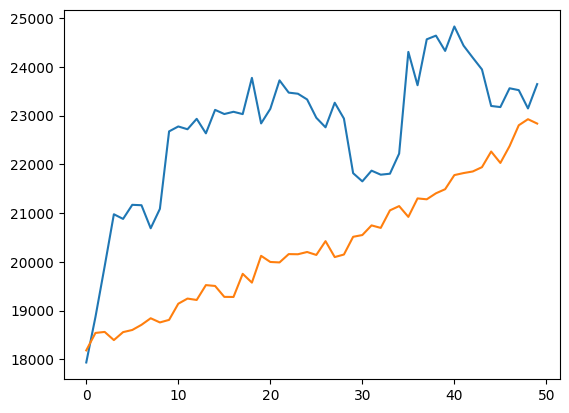

In [27]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.savefig("small_plot.png", dpi=300)
plt.show();

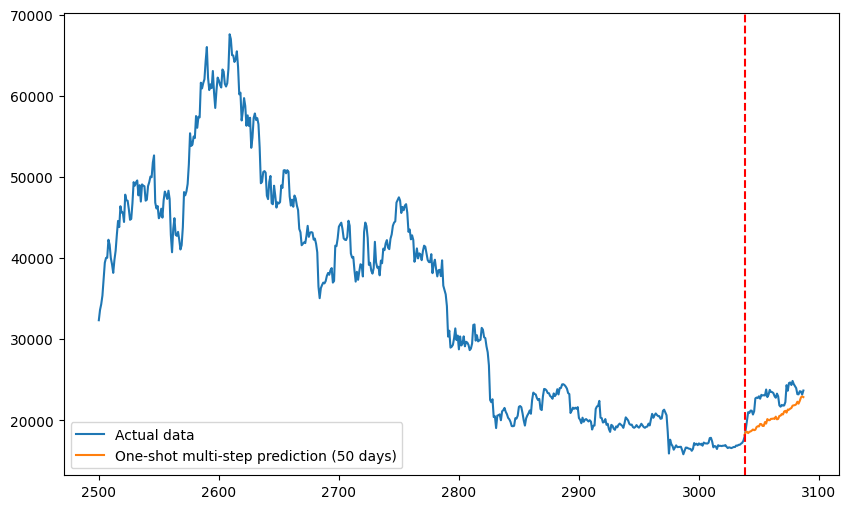

In [28]:
plt.figure(figsize=(10,6)) #plotting
a = [x for x in range(2500, len(y))]
plt.plot(a, y[2500:], label='Actual data');
c = [x for x in range(len(y)-50, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction (50 days)')
plt.axvline(x=len(y)-50, c='r', linestyle='--')
plt.legend()
plt.show()